In [1]:
import pandas as pd 
import numpy as np 
from math import sqrt

import seaborn as sns
import matplotlib.pyplot as plt

from catboost import CatBoostRegressor

from sklearn.preprocessing import  StandardScaler, OneHotEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score


In [2]:
pd.set_option('display.max_columns', None)

In [3]:
df = pd.read_csv('dataset.csv',index_col=0)

# Prepare data

In [4]:
df.drop(['date_install','first_command_time','birthday','sex','time_confirm_email'],axis=1,inplace=True)

In [5]:
int_cols = df.select_dtypes(include=['int', 'float']).columns
int_cols = int_cols.drop('target_game_currency')
obj_cols = ['country','network_name']

In [6]:
def prepare_obj_data(df, obj_cols):
    '''
    Prepare data with type object
    
    Args:
        df: pd.DataFrame
        obj_cols: list of str 
    Returns:
        pd.DataFrame
    '''
    
    cheat_count_is_cheater = df['is_cheater'].value_counts().index[0]
    cheat_count_has_email = df['has_email'].value_counts().index[0]
    
    df['is_cheater'] = df['is_cheater'].fillna(cheat_count_is_cheater)
    df['has_email'] = df['has_email'].fillna(cheat_count_has_email)
    
    df['country'] = df['country'].fillna('other')
    df['network_name'] = df['network_name'].fillna('other')

    encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    for column in obj_cols:
        encoded_data = encoder.fit_transform(df[[column]])
        encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out([column]))
        df = pd.concat([df, encoded_df], axis=1)
    
    df.drop(obj_cols, axis=1, inplace=True)
        
    return df


In [7]:
df = prepare_obj_data(df, obj_cols)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [8]:
X = df.drop('target_game_currency', axis = 1)
y = df['target_game_currency']

In [9]:
y_stratified = (y > 0).astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, stratify=y_stratified, random_state=42)


## Catboost

In [10]:
def plot_importance(model, X):
    '''
    Function for plot regression coef
    '''
    try:
        fold_importance_df = pd.DataFrame()
        fold_importance_df["feature"] = X.columns
        fold_importance_df["importance"] = model.feature_importances_
        td = fold_importance_df.sort_values('importance', ascending=False)
        sns.barplot(x="importance", y="feature", data=td.head(10), palette="Blues_d")
        plt.show()
    except:
        return []

In [11]:
def SMAPE(y_true, y_pred):
    """
    SMAPE score
    """
    denominator = (np.abs(y_true) + np.abs(y_pred))
    diff = np.where(denominator == 0, 0, 2 * np.abs(y_true - y_pred) / denominator)
    return np.mean(diff)


def custom_smape_score(estimator, X, y):
    '''
    SMAP for cross-validation
    '''
    y_pred = estimator.predict(X)
    smape = SMAPE(y, y_pred)
    return -smape

In [22]:
def train_model(model_obj, X_train, y_train, num_folds ,scoring,cross_val = False):
    '''
    Train model
    '''
    model = model_obj
    print(model.fit(X_train, y_train, verbose=50, plot=True))
    
    if cross_val:
        cv_scores = cross_val_score(model, X_train, y_train, cv = num_folds, scoring = scoring)
        print("Cross_validation:", cv_scores)
    
    td = plot_importance(model, X_train)
    
    return model, td

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 484.1682889	total: 56.1ms	remaining: 28s
50:	learn: 433.8854273	total: 2.15s	remaining: 18.9s
100:	learn: 428.9690557	total: 4.23s	remaining: 16.7s
150:	learn: 428.4892535	total: 6.28s	remaining: 14.5s
200:	learn: 427.9060742	total: 8.38s	remaining: 12.5s
250:	learn: 427.5022291	total: 10.5s	remaining: 10.4s
300:	learn: 427.2520089	total: 12.5s	remaining: 8.25s
350:	learn: 427.2520089	total: 14.5s	remaining: 6.16s
400:	learn: 427.1783603	total: 16.5s	remaining: 4.08s
450:	learn: 427.1783603	total: 18.6s	remaining: 2.02s
499:	learn: 427.1783603	total: 20.6s	remaining: 0us
0:	learn: 488.9098849	total: 49ms	remaining: 24.5s
50:	learn: 437.3353180	total: 1.79s	remaining: 15.8s
100:	learn: 431.6915648	total: 3.47s	remaining: 13.7s
150:	learn: 430.5938317	total: 5.15s	remaining: 11.9s
200:	learn: 430.1702938	total: 6.84s	remaining: 10.2s
250:	learn: 429.9300858	total: 8.49s	remaining: 8.43s
300:	learn: 429.7927828	total: 10.2s	remaining: 6.71s
350:	learn: 429.7920473	total: 11.8s	r

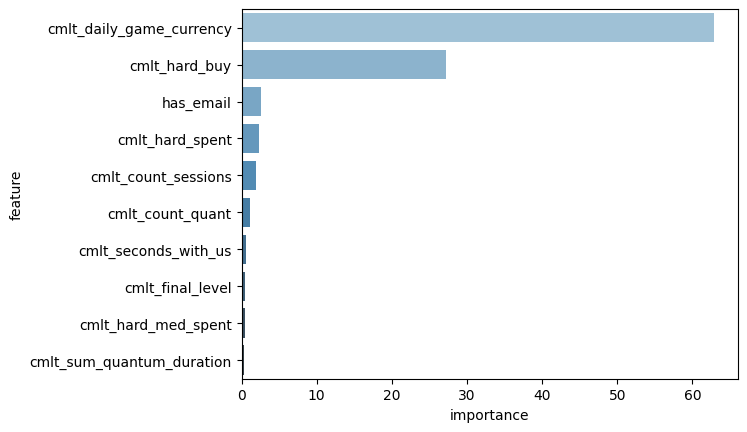

In [30]:
params = {
    'iterations': 500,
    'depth': 3,
    'loss_function': 'MAE',
    'random_state': 42,
    'l2_leaf_reg': 20,
    'verbose': 50,
    'early_stopping_rounds': 20,
    'thread_count': -1
}

model, features = train_model(CatBoostRegressor(**params),
                              X_train, 
                              y_train,
                              5,
                              scoring='neg_mean_absolute_error',
                              cross_val=True)

In [31]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

In [33]:
print('Train SMAPE: ', SMAPE(y_train, y_pred_train))
print('Test SMAPE: ', SMAPE(y_test, y_pred_test))

print('Train RMSE: ',  np.sqrt(mean_squared_error(y_train, y_pred_train)))
print('Test RMSE: ',  np.sqrt(mean_squared_error(y_test, y_pred_test)))

print('Train MAE: ',  mean_absolute_error(y_train, y_pred_train))
print('Test MAE: ',  mean_absolute_error(y_test, y_pred_test))

Train SMAPE:  1.9775295841598137
Test SMAPE:  1.9779588820492802
Train RMSE:  8305.567862229665
Test RMSE:  7192.958987416299
Train MAE:  427.17836164465325
Test MAE:  378.8944565109868
